## <center>Global Biomass Estimation Using S2 and GEDI</center>
### <center>Convolutional Neural Network (CNN)</center>
**<center>This ipynb notebook was created by Oliver Hegi</center>**

This notebook contains the code for a convolutional neural network (CNN). The predictors are Sentinel-2 images and the target is a set of GEDI biomass estimations.

#### STEP 1 – Load the required packages

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### STEP 2 – Load the input and target data.
The data can be found in the folder /DATA

In [2]:
directory_train = "DATA/Train_Test_Split_by_Geography/East_of_40W_Data/"
Y = np.array(pd.read_csv(f'{directory_train}l_GEDI.csv', index_col=0)['0']) # of shape (10000,)
X = np.load(f'{directory_train}l_S2.npy', allow_pickle=True) # of shape (10000, 111, 111, 3) where each image is 111 pixels tall and 111 pixels wide and has three layers for RGB

directory_test = 'DATA/Train_Test_Split_by_Geography/West_of_40W_Data/'
y_test = np.array(pd.read_csv(f'{directory_test}l_GEDI.csv', index_col=0)['0']) # of shape (10000,)
x_test = np.load(f'{directory_test}l_S2.npy', allow_pickle=True) # of shape (10000, 111, 111, 3) where each image is 111 pixels tall and 111 pixels wide and has three layers for RGB

#### STEP 3 – Standardize the data

In [3]:
mean, std = X.mean(), X.std()
X = (X - mean)/std # Only the input data needs to be standardized

test_mean, test_std = x_test.mean(), x_test.std()
x_test = (x_test - test_mean)/test_std

#### STEP 4 – Train/test split

In [4]:
np.random.seed(1)
x_trn, x_val, y_trn, y_val = train_test_split(X, Y, test_size=0.2) #train vs validate is drawn from the in-sample data

#### STEP 5 – CNN hyperparematers

In [5]:
activation     = 'relu' # activation function
learning_rate  = 0.1
batch_size     = 512
num_epochs     = 50

# Define Early Stop
Early_Stop = EarlyStopping(monitor='val_loss', patience=5)

#### STEP 6 – Set up model

In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=5, strides=2, activation=activation, padding='same', input_shape=(111, 111, 3)))
model.add(Conv2D(64, kernel_size=3, strides=2, activation=activation, padding='same'))
model.add(Conv2D(128, kernel_size=3, strides=2, activation=activation, padding='same'))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')

#### STEP 7 – Run model

In [7]:
history = model.fit(x_trn, y_trn, batch_size=batch_size, epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[Early_Stop])

Epoch 1/50


2022-12-25 11:20:54.644864: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 2s 476ms/step - loss: 5011.4175 - val_loss: 3547.8635
Epoch 2/50
4/4 [==============================] - 2s 480ms/step - loss: 4153.1221 - val_loss: 3823.1965
Epoch 3/50
4/4 [==============================] - 2s 456ms/step - loss: 4220.8979 - val_loss: 3087.6865
Epoch 4/50
4/4 [==============================] - 2s 457ms/step - loss: 4190.7925 - val_loss: 3084.0444
Epoch 5/50
4/4 [==============================] - 2s 459ms/step - loss: 4053.1960 - val_loss: 3095.1025
Epoch 6/50
4/4 [==============================] - 2s 457ms/step - loss: 4016.0942 - val_loss: 2993.1934
Epoch 7/50
4/4 [==============================] - 2s 455ms/step - loss: 3973.6121 - val_loss: 2973.7522
Epoch 8/50
4/4 [==============================] - 2s 457ms/step - loss: 3965.9099 - val_loss: 2980.5061
Epoch 9/50
4/4 [==============================] - 2s 459ms/step - loss: 3947.4084 - val_loss: 2959.3911
Epoch 10/50
4/4 [==============================] - 2s 463ms/step - loss: 39

#### STEP 8 – Plot history

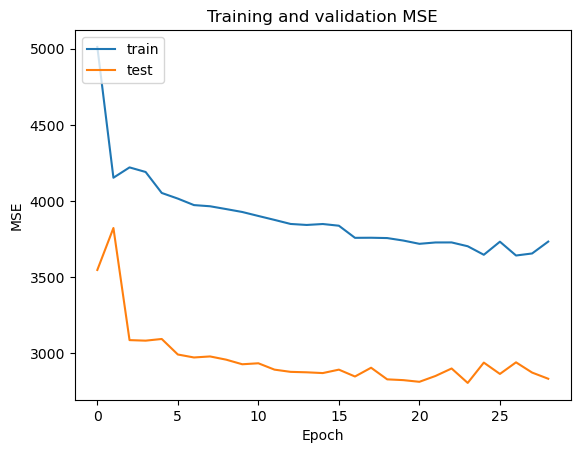

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### STEP 9 – Out-of-sample test accuracy
Test the accuracy of the model on completelty untouched data

In [9]:
y_hat = model.predict(x_test, verbose=0) #x_test is untouched data
mean_squared_error(y_test, y_hat)

7070.85534006851

#### STEP 10 – Plot predictions against actual values

[]

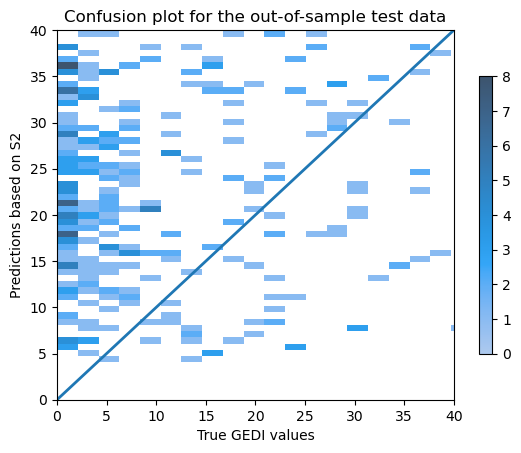

In [10]:
ax = sns.histplot(x=y_test, y=np.reshape(y_hat,len(y_hat)), bins=400, cbar=True, cbar_kws=dict(shrink=0.75))
ax.set_ylabel('Predictions based on S2')
ax.set_xlabel('True GEDI values')
ax.axline([0, 0], [1, 1], linewidth=2)
lim = 40
ax.set_xlim(0,lim)
ax.set_ylim(0,lim)
ax.set_title('Confusion plot for the out-of-sample test data')
ax.plot()